In [1]:
import sys
sys.path.append("../dev_scripts/")
import exp_tools
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
from fri import bounds,plot_dendrogram_and_intervals
from fri import *
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Data creation


* We want two features which can be replace each other without being correlated.
* To show the difference to a correlated pair, we add two of those and some other irrelevant features.

In [2]:
def gen_quadrant_problem_2weak(n=5000, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
    rs = random_state
    X = rs.rand(n, 2)
    class1 = 2 * rs.rand(n) - 1
    class2 = 2 * rs.rand(n) - 1
    
    X2, y2 = genClassificationData(n_samples=n, n_features=5, n_strel=0, n_redundant=2,
                                   n_repeated=0, flip_y=0, random_state=rs)
    # Stack the two constructed with another toy set
    X = np.hstack([X, X2])
    X = StandardScaler().fit_transform(X)
    y = X[:, 0] + X[:, 1] + X[:, 2] > 0

    return X, y

In [3]:
n = 1000
rs = np.random.RandomState(125)
X,y = gen_quadrant_problem_2weak(n=n,random_state=rs)


Generating dataset with d=5,n=1000,strongly=0,weakly=2, partition of weakly=None


### Plot of first two features

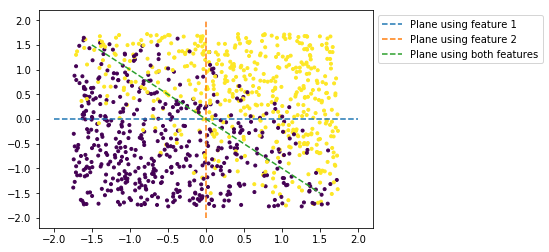

In [4]:
plt.scatter(*X[:,0:2].T,c=y,marker=".")
plt.plot((-2,2),(0,0),"--")
plt.plot((0,0),(-2,2),"--")
plt.plot((-1.5,1.5),(1.5,-1.5),"--")
plt.legend(["Plane using feature 1", "Plane using feature 2", "Plane using both features"],loc="best",bbox_to_anchor=(1,1))

# Normal model fit

In [5]:
f = FRIClassification(debug=True)
f.fit(X,y)

loss 1.93837278786e-07
L1 273.687767324
offset 0.330116021378049
C 100
score 1.0
coef:
[[ 81.96068917]
 [ 83.67542842]
 [ 40.55688645]
 [-40.55688569]
 [ -0.59241584]
 [ -0.97467071]
 [ -0.49008492]]


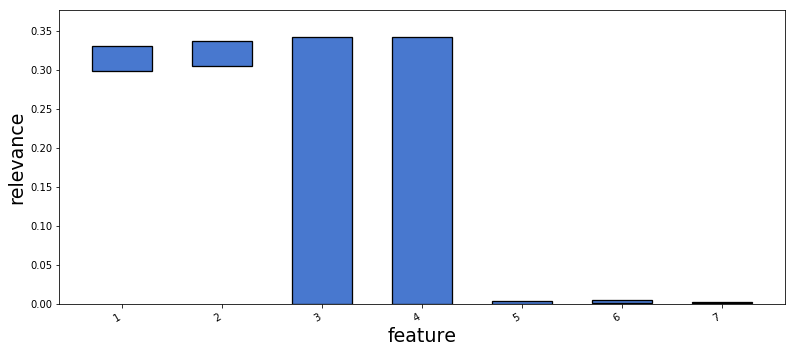

In [6]:
p = plotIntervals(f.interval_)

### Observation
both first two features strongly relevant, model uses both features

# Model fit with relaxed constraints
We relax the problem to demonstrate the example better, the grouping works without relaxation, too.

In [7]:
f = FRIClassification(debug=True,optimum_deviation=0.15,C=0.0025)
f.fit(X,y)

loss 584.142439811
L1 0.984122367109
offset 0.04952781382861671
C 0.0025
score 0.852752329287
coef:
[[  3.85694212e-01]
 [  3.86644422e-01]
 [  4.17099685e-02]
 [ -4.17099779e-02]
 [ -1.38997317e-15]
 [  1.82524235e-15]
 [ -9.92735913e-16]]


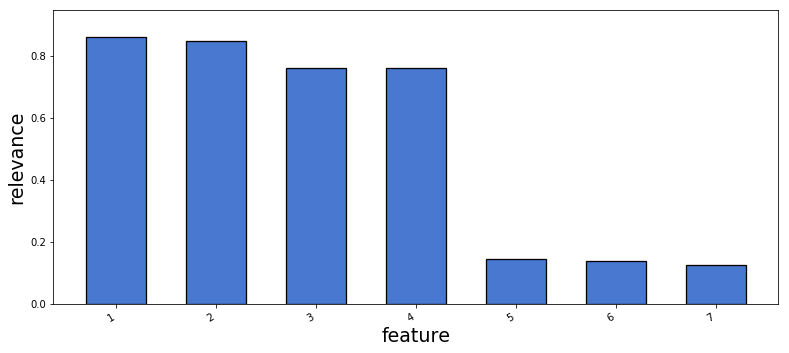

In [8]:
p = plotIntervals(f.interval_)

#### Observation 
First two features turned into weakly relevant, One of both can fulfill function in the model

# Question: How to find these pairings in a given dataset?

We use our relevance bounds to find the features which take over the role of other features.

* We constrain each feature separately to one of its relevance bounds and solve the relevance bounds for all others.
* We look at the difference between the unconstrained solution (seen above) and the constrained one for each of these separate optimizations.

## Constraining the first feature to the minimum

In [9]:
preset = np.empty(shape=(X.shape[1], 2))
preset.fill(np.nan)
preset[0] = f.unmod_interval_[0,0]

Our preset vector only constrains the first feature to a single value. 
In our case the minimum value was zero (or very close to it given the numerical inaccuracies of the solver)

A range of values is also possible for other use cases.

In [10]:
preset

array([[  6.77803639e-13,   6.77803639e-13],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan]])

In [11]:
# the method run with the preset
constrained_rangevector_for_dim0, _,_,_ = f._main_opt(f.X_,f.y_,f.optim_loss_,f.optim_L1_,rs,False,presetModel=preset)

Resulting in relevance bounds where feature two is crucial for model performance and having a lower bound > 0.

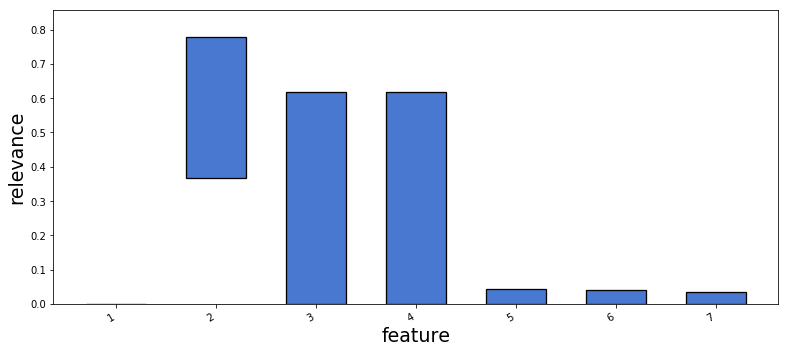

In [12]:
p = plotIntervals(constrained_rangevector_for_dim0)

We want to group features which have similar role.

We define similarity as the context of two features to all other features.
For the context we look at the difference between the unconstrained solution and the constrained one.

In [13]:
# Difference for one feature for one relevance bound
diff_to_constrained_dim0 = f.unmod_interval_[:,0] - constrained_rangevector_for_dim0[:,0]


preset = np.empty(shape=(X.shape[1], 2))
preset.fill(np.nan)
preset[1] = f.unmod_interval_[1,0]
constrained_rangevector_for_dim1, _,_,_ = f._main_opt(f.X_,f.y_,f.optim_loss_,f.optim_L1_,rs,False,presetModel=preset)

# # Difference for another feature
diff_to_constrained_dim1 = f.unmod_interval_[:,0] - constrained_rangevector_for_dim1[:,0]

In reality we look at the difference for both relevance bounds.

For context comparison we use a distance measure which nulls out the pairwise difference and only looks at the difference to all other features.

For this we use a modified euclidean distance.

In [14]:
# Modified euclidean distance
def distance(u,v):
    u = np.asarray(u)
    v = np.asarray(v)
    diff = (u - v)**2
    # Null out the direct pairwise difference
    diff[u == 0] = 0
    diff[v == 0] = 0
    return np.sqrt(np.sum(diff))

### Exemplary distance for feature 0 and 1, in reality we also look at the values when relevance bound is maximal

In [15]:
distance(diff_to_constrained_dim0,diff_to_constrained_dim1)

3.6005829617300731e-13

## We repeat that for all features


In [16]:
clust, link, feat_points,dist_mat = f.community_detection2()


In [17]:
import scipy
dist_mat = scipy.spatial.distance.squareform(dist_mat)

## Distances represented in matrix form

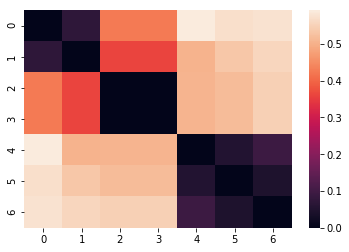

In [18]:
sns.heatmap(dist_mat)

### We can use this distance matrix for hierarchical clustering to get a nice overview
the clustering uses single linkage for inter cluster distances

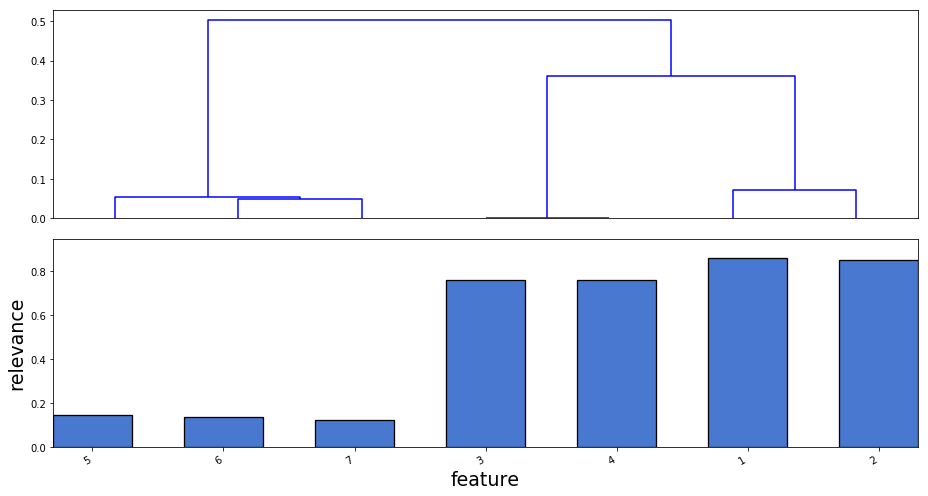

In [19]:
p = plot_dendrogram_and_intervals(f.interval_,link)

We can observe that both pairs of related features (non-correlated (1,2) and correlated ones (3,4) are grouped together.

Additionally, also irrelevant features are often found in a big separated cluster.

# Correlation based grouping

As a comparison a correlation based grouping would look like the following

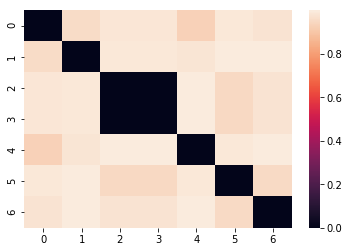

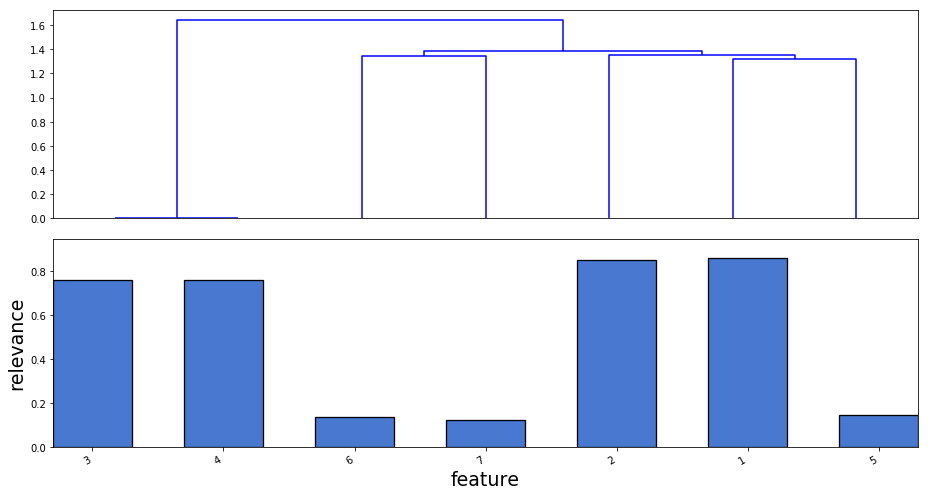

In [22]:
corr_pd = pd.DataFrame(X).corr()

corr_pd = 1-corr_pd.abs()
corr_pd = corr_pd.values

sns.heatmap(corr_pd)

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
z = linkage(corr_pd,method="single")
threshold = 0.55*np.max(z[:, 2])
p = plot_dendrogram_and_intervals(f.interval_,z)

In [23]:
pd.DataFrame(X).corr()

,0,1,2,3,4,5,6
0,1.000000,0.041688,-0.013250,0.013250,0.068489,0.009713,-0.024199
1,0.041688,1.000000,0.009897,-0.009897,0.017740,0.001767,0.001497
2,-0.013250,0.009897,1.000000,-1.000000,-0.002976,0.050858,0.021815
3,0.013250,-0.009897,-1.000000,1.000000,0.002976,-0.050858,-0.021815
4,0.068489,0.017740,-0.002976,0.002976,1.000000,-0.010376,-0.000962
5,0.009713,0.001767,0.050858,-0.050858,-0.010376,1.000000,-0.047092
6,-0.024199,0.001497,0.021815,-0.021815,-0.000962,-0.047092,1.000000
